In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 15:21:41 2018

@author: james.macdonald
"""

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import datetime as dt
import random, subprocess, os
from scipy.io import loadmat

tf.__version__

/Users/jmacdonald/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.8.0'

In [2]:
def download_dataset(url):
    fname = url.split("/")[-1]
    if fname not in os.listdir('./'):
        cmd = 'wget '+url
        subprocess.call(cmd, shell=True)
    return fname
    
train = download_dataset('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
test = download_dataset('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')
extra = download_dataset('http://ufldl.stanford.edu/housenumbers/extra_32x32.mat')

def to_greyscale(data):
    return np.dot(data, np.array([0.299, 0.587, 0.114]))

In [3]:
def get_shuffled_index(count_obs, mbatch_size = 250):
    ix = np.array(range(count_obs))
    np.random.shuffle(ix)
    return ix

class Dataset(object):
    
    def __init__(self, location):
        data_dic = loadmat(location)
        self._images = to_greyscale(np.array([data_dic['X'][:,:,:,i] for i in range(data_dic['X'].shape[3])]))
        self._num_examples = len(self._images)
        self._cls = np.array(data_dic['y'][:,0])
        self._cls[self._cls==10] = 0
        labels = np.zeros([len(self._cls),10])
        labels[range(len(labels)),self._cls] = 1
        self._labels = labels
        self._index_in_epoch = 0
        self._img_names = self._labels
        self._epochs_done = 0
        
    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples
    

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]
    
def read_train_sets():
    class DataSets(object):
        pass
    data_sets = DataSets()
    data_sets.train = Dataset(train)
    data_sets.validation = Dataset(test)
    
    return data_sets

data = read_train_sets()

In [6]:
def plot_images(images, labels, img_shape=None, cls_pred=None):
    fig, axes = plt.subplots(3, 5)

    for ix, ax in enumerate(axes.flat):
        ax.imshow(images[ix])
        xlabel = "True: {0}".format(labels[ix])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

[ 5561  1120 23902 23560  5291 20304 10745 21000  9260 25691 19185   543
  6322  7257  6852]


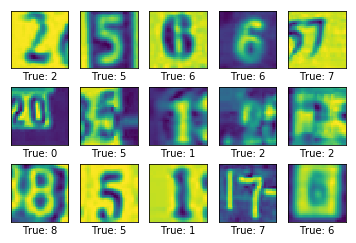

In [23]:
validation_size = 0.2
img_dims = 32
#num_channels = 1
num_classes = 10
batch_size = 132
train_batch_size = batch_size

img_shape = (img_dims, img_dims)
img_dims_flat = img_shape[0] * img_shape[1] #* img_shape[2]

np.random.seed(4)
ix = np.random.choice(range(len(data.validation.images)), replace=False, size=15)
print(ix)
images = data.validation.images[ix]
labels = data.validation.cls[ix]

plot_images(images=images, labels=labels)

In [8]:
# Set parameters for CNN layers

convolution_params = {
    'layer_1':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_2':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':16},
    'layer_3':{'fSize':5, 'fN':64, 'sSize':1, 'activation':'relu', 'channels':32},
    'layer_4':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':64}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

regularization_coefficient = 0.01

In [9]:
activation_dictionary = {'relu':tf.nn.relu,'lrelu':tf.nn.leaky_relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

def new_weights(shape):
    new_weight = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(new_weight)

def new_biases(length):
    new_bias = tf.constant(0.05, shape=[length])
    return tf.Variable(new_bias)

def new_conv_layer(previous_layer,param_dic):
    p = param_dic
    weights = new_weights(shape=[p['fSize'], p['fSize'], p['channels'], p['fN']])
    biases = new_biases(length=p['fN'])
    
    layer = tf.nn.conv2d(input=previous_layer,
                         filter=weights,
                         strides=[1, p['sSize'], p['sSize'], 1],
                         padding='SAME')

    layer += biases
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')
    
    activation = activation_dictionary[p['activation']]
    output = activation(layer)
    return output, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, use_relu=True, dropout=0.05): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 1-dropout)
    return layer, weights


In [10]:
label = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
label_class = tf.argmax(label, axis=1)

x = tf.placeholder(tf.float32, shape=[None, img_dims, img_dims], name='x')
x_image = tf.reshape(x, [-1, img_dims, img_dims, 1])

p = convolution_params['layer_1']
layer_conv1, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p) 

p = convolution_params['layer_2']
layer_conv2, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 

p = convolution_params['layer_3']
layer_conv3, weights_conv3 = new_conv_layer(previous_layer=layer_conv2, param_dic=p) 

p = convolution_params['layer_4']
layer_conv4, weights_conv4 = new_conv_layer(previous_layer=layer_conv3, param_dic=p)

In [11]:

layer_flat, num_features = flatten_layer(layer_conv4)

p = fc_params['layer_1']
layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=p['nodes'],
                         use_relu=True)

p = fc_params['layer_2']
layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=p['nodes'],
                         num_outputs=num_classes,
                         use_relu=False)

In [12]:
y_hat = tf.nn.softmax(layer_fc2)
y_hat_class = tf.argmax(y_hat, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=label)

cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_hat_class, label_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [27]:
def optimize(num_iterations):
    global total_iterations
    global train_scores

    for i in range(num_iterations):
        j = total_iterations + i
        x_batch, label_batch, _, _ = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, label: label_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if j % 10 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)
            if j % 100 == 0:
                msg = "Iteration Number: {%d}, Training Accuracy: {:.1f%}"
                print(msg.format(j + 1, acc))
    total_iterations += num_iterations

In [28]:
%%time
np.random.seed(1)
session = tf.Session()
session.run(tf.global_variables_initializer())

total_iterations = 0
train_scores = []

optimize(num_iterations=5000)

Optimization Iteration:      1, Training Accuracy:  15.9%
Optimization Iteration:    101, Training Accuracy:  34.8%
Optimization Iteration:    201, Training Accuracy:  40.9%
Optimization Iteration:    301, Training Accuracy:  47.0%
Optimization Iteration:    401, Training Accuracy:  50.0%
Optimization Iteration:    501, Training Accuracy:  56.8%
Optimization Iteration:    601, Training Accuracy:  68.9%
Optimization Iteration:    701, Training Accuracy:  62.9%
Optimization Iteration:    801, Training Accuracy:  74.2%
Optimization Iteration:    901, Training Accuracy:  82.6%
Optimization Iteration:   1001, Training Accuracy:  75.0%
Optimization Iteration:   1101, Training Accuracy:  69.7%
Optimization Iteration:   1201, Training Accuracy:  77.3%
Optimization Iteration:   1301, Training Accuracy:  70.5%
Optimization Iteration:   1401, Training Accuracy:  80.3%
Optimization Iteration:   1501, Training Accuracy:  78.0%
Optimization Iteration:   1601, Training Accuracy:  68.9%
Optimization I

In [32]:
x_validate = data.validation.images
y_validate = data.validation.labels
test_dic = {x:x_validate, label:y_validate}
predicted = session.run(y_hat_class, feed_dict=test_dic)

In [37]:
acc = np.mean(data.validation.cls==predicted)
acc

0.8417332513829133